In [ ]:
!pip install jieba


[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: pip install --upgrade pip


In [319]:
import numpy as np
import pandas as pd
import jieba

In [320]:
data = pd.read_excel('/home/lll/Documents/大创数据/data_.xlsx')

In [321]:
data_ = data['goods_name']
data = data['goods_name']

In [322]:
data__ = []
for i in range(len(data)):
    data__.append(list(jieba.cut(data[i])))
    data[i] = list(jieba.cut(data[i]))

In [323]:
dict_ = []
for i in range(len(data_)):
    for j in data_[i]:
        dict_.append(j)

In [324]:
dict_ = np.unique(dict_)

In [325]:
import re
p = re.compile(r'[\u4e00-\u9fa5]*') 

In [326]:
re.search(p,'sed').group()

''

In [327]:
a = []
for i in range(len(dict_)):
    if re.search(p,dict_[i]).group()=='':
       a.append(i)
dict__ = np.delete(dict_,a)              

In [328]:
from gensim.models import Word2Vec
model = Word2Vec(data)
model.wv.save_word2vec_format('word2vec.vector',binary=False)

In [329]:
dict_ = dict(zip(dict_,np.arange(len(dict_))))

In [330]:
for i in range(len(data__)):
    mm = []
    for j in data__[i]:
        mm.append(dict_[j])
    data__[i] = mm    

In [341]:
def apply_to_zeros(lst, dtype=np.int64):
    inner_max_len = max(map(len, lst))
    result = np.zeros([len(lst), inner_max_len], dtype)
    for i, row in enumerate(lst):
        for j, val in enumerate(row):
            result[i][j] = val
    return result

In [342]:
data = apply_to_zeros(data__)

In [369]:
import torch as t
from torch import nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader
import utils
import torch.optim as optim
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim  
import matplotlib.pyplot as plt
import numpy as np

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(2826, 200)
        self.fc2_mu = nn.Linear(200, 10)
        self.fc2_log_std = nn.Linear(200, 10)
        self.fc3 = nn.Linear(10, 200)
        self.fc4 = nn.Linear(200, 2826)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        mu = self.fc2_mu(h1)
        log_std = self.fc2_log_std(h1)
        return mu, log_std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        recon = torch.sigmoid(self.fc4(h3))  # use sigmoid because the input image's pixel is between 0-1
        return recon

    def reparametrize(self, mu, log_std):
        std = torch.exp(log_std)
        eps = torch.randn_like(std)  # simple from standard normal distribution
        z = mu + eps * std
        return z

    def forward(self, x):
        mu, log_std = self.encode(x)
        z = self.reparametrize(mu, log_std)
        recon = self.decode(z)
        return recon, mu, log_std

    def loss_function(self, recon, x, mu, log_std) -> torch.Tensor:
        recon_loss = 0
        for i in x:
            recon_ = F.mse_loss(recon, i, reduction="sum")  # use "mean" may have a bad effect on gradients
            recon_loss += recon_
        recon_loss = recon_loss/len(x)
        kl_loss = -0.5 * (1 + 2*log_std - mu.pow(2) - torch.exp(2*log_std))
        kl_loss = torch.sum(kl_loss)                        #kl散度
        loss = recon_loss + kl_loss
        return loss


In [243]:
loss = vae.loss_function(recon, vae.data, mu, log_std)
loss.backward()    
optimizer = optim.SGD(vae.parameters(), lr=0.001, momentum=0.9)
optimizer.step()  

In [370]:
def trainandsave(data,epoch):
    # 神经网络结构
    vae = VAE()
    vae.data = torch.Tensor(data)
    optimizer = optim.SGD(vae.parameters(), lr=0.001, momentum=0.9)   # 学习率为0.001
    # 训练部分
    for epoch in range(epoch):
                            # 每个epoch要训练所有的图片，每训练完成200张便打印一下训练的效果（loss值）
        running_loss = 0.0  # 定义一个变量方便我们对loss进行输出
        loss_data = []
        for i, data in enumerate(vae.data, 0):  # 这里我们遇到了第一步中出现的trailoader，代码传入数据
            # enumerate是python的内置函数，既获得索引也获得数据
            # get the inputs
           
            optimizer.zero_grad()        # 梯度置零，因为反向传播过程中梯度会累加上一次循环的梯度

            # forward + backward + optimize
            recon, mu, log_std = vae(data)      # 把数据输进CNN网络net
            loss = vae.loss_function(recon, vae.data, mu, log_std)  # 计算损失值
            loss.backward()                 # loss反向传播
            optimizer.step()   
                            # 反向传播后参数更新 
            running_loss += loss.data      # loss累加
            if i%200 ==0:
               print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 200))  # 然后再除以200，就得到这两百次的平均损失值
               loss_data.append(running_loss)
               running_loss = 0.0  # 这一个200次结束后，就把running_loss归零，下一个200次继续使用
        plt.plot(np.arange(len(loss_data)),loss_data)
    print('Finished Training')
    # 保存神经网络
    torch.save(vae, 'vae.pkl')                      # 保存整个神经网络的结构和模型参数
    torch.save(vae.state_dict(), 'vae_params.pkl')  # 只保存神经网络的模型参数

[1,     1] loss: 3.620
[1,   201] loss: 82.562
[1,   401] loss: 21.011
[1,   601] loss: 24.258
[1,   801] loss: 26.682
[1,  1001] loss: 21.812
[1,  1201] loss: 28.888
[1,  1401] loss: 26.073
[1,  1601] loss: 21.835
[1,  1801] loss: 22.475
[1,  2001] loss: 19.814
[1,  2201] loss: 17.081
[1,  2401] loss: 13.851
[1,  2601] loss: 18.159
[1,  2801] loss: 18.837
[1,  3001] loss: 17.239
[1,  3201] loss: 15.440
[1,  3401] loss: 13.603
[1,  3601] loss: 12.021
[1,  3801] loss: 12.421
[1,  4001] loss: 12.692
[1,  4201] loss: 12.605
[1,  4401] loss: 11.805
[2,     1] loss: 0.056
[2,   201] loss: 11.460
[2,   401] loss: 12.074
[2,   601] loss: 11.583
[2,   801] loss: 11.641
[2,  1001] loss: 14.072
[2,  1201] loss: 11.825
[2,  1401] loss: 12.626
[2,  1601] loss: 12.656
[2,  1801] loss: 11.512
[2,  2001] loss: 11.359
[2,  2201] loss: 11.238
[2,  2401] loss: 11.276
[2,  2601] loss: 11.157
[2,  2801] loss: 11.034
[2,  3001] loss: 11.098
[2,  3201] loss: 10.929
[2,  3401] loss: 11.089
[2,  3601] loss: 1

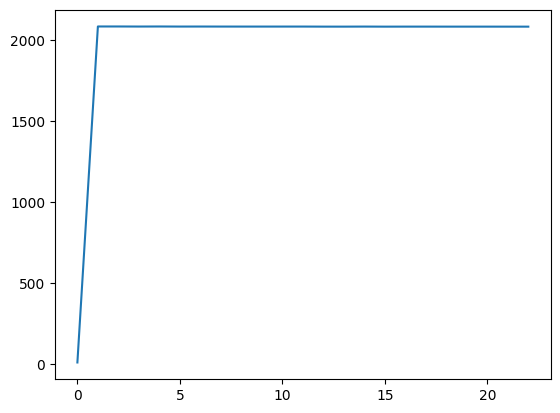

In [371]:
trainandsave(data_vae,5)

In [372]:
def reload_net():
    trainednet = torch.load('vae.pkl')
    return trainednet

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [373]:
reload_net()

VAE(
  (fc1): Linear(in_features=2826, out_features=200, bias=True)
  (fc2_mu): Linear(in_features=200, out_features=10, bias=True)
  (fc2_log_std): Linear(in_features=200, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=200, bias=True)
  (fc4): Linear(in_features=200, out_features=2826, bias=True)
)

In [ ]:
vae.